In [2]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (plot_cliff_walking, rew_ep_plot);
from data_processing.neural_networks.RL_Reinforced_Learning.Rl_function_approximation import env_approx
from IPython.display import clear_output
clear_output()
#from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

# Eligibility Traces ($\lambda$)
*   n-step methods delay evaluation for n steps. We can call it _backward view_. In extreme they converge into Monte-Carlo method
    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n \hat v_{t+n -1}(S_{t+n}, \vec{w}_{t+n-1})$$
*   One may construct a target by creating a _compound return_, which is a weighted sum (average) of different n-step returns.

    For example an average of 2-step and 4-step return:
    $$\frac{1}{2} G_{t:t+2} + \frac{1}{2} G_{t:t+4}$$
    We may ask for sum of weights to be 1, as to signify the importance of each n-step return
*   We can sum all 'partial' returns $G_{t:t+p}$ from sequence on rewards of $n$ steps with 'decaying' weights that are proportional to $\lambda^{n-1}$ $(\lambda \in [0,1])$

    For these weights to work, we have to normalize each by $(1-\lambda)$
    $$\boxed{G_n^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n}} $$
    ***
    Weight normalization:
    $$\sum_{n=1}^\infty \lambda^{n-1}  = \lambda^0 + \lambda^1+\dots = \sum_{n=0}^\infty \lambda^{n}$$
    Geometric series:
    $$\sum_{n=0}^\infty a r^n = \frac{a}{1-r} \rightarrow \sum_{n=1}^\infty \lambda^{n-1} = \sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot$$
    $$\sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot \bigg| (1- \lambda)  \longrightarrow \boxed{(1- \lambda) \sum_{n=1}^\infty \lambda^{n-1}= 1}$$
    ***
*   $\lambda$ methods work in reverse 

On termination step $T$:
$$t+n_T = T \rightarrow n_T = T - t$$
$$\lambda^{n_T-1} G_{t:t+n_T}  = \lambda^{T- t -1} G_{t:T} = \lambda^{T- t -1} G_t $$
We can split $G_t^\lambda $ into two terms
$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n} = (1-\lambda)\sum_{n=1}^{n_T - 1 = (T - t) - 1}\lambda^{n-1} G_{t:t+n} + (1-\lambda)\sum_{n= n_T = T - t}^\infty \lambda^{n-1} G_{t:t+n}$$
*   _Im not sure what happens to second term past termination state. $ G_{t:T} = G_{t:T + 1} = G_t$?_
*   _if we terminate sum past $T$ then right term should be $(1-\lambda) \cdot \lambda^{T- t -1} G_t$. Why in the book its only $\lambda^{T- t -1} G_t$?_

Anyway, result in the book is:
$$\boxed{G_t^\lambda = (1-\lambda)\sum_{n=1}^{(T - t) - 1}\lambda^{n-1} G_{t:t+n} + \lambda^{T- t -1} G_t}$$
Which shows that in case of $\lambda = 1$
$$G_t^{\lambda = 1} = 0\cdot \sum_{n=1}^{(T - t) - 1}G_{t:t+n} + 1^{T-t-1} \cdot G_t = G_t$$
which i a Monte Carlo return. And if $\lambda = 0$
$$G_t^{\lambda=0} = 1\cdot [ 0^0 \cdot G_{t:t+1} + 0^1 \cdot G_{t:t+2} + \dots] + 0^{T-t-1} \cdot  G_t = G_{t:t+1} + 0 + \dots$$

so we see that extreme values of $\lambda$ change composite return to either TD(0) or MC returns:
*   $G_t^{\lambda = 1} = G_t$
*   $G_t^{\lambda = 0} = G_{t:t+1}$


# Semi-gradient TD($\lambda$) for estimating $\hat v \approx v_\pi$
Eligibility trace vector holds history visited states. 

Vectors shape is the same as the shape of f-n approximation parameters, each entries is relate to state or states.

$$ \boxed{\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + \nabla_w \hat v(S_t, \vec{w}_t)}$$

Expression has two parts:
1.  term $\nabla_w \hat v(S_t, \vec{w}_t)$ shows which v approximation parameters (might think which states) are relevant/active now. Assign these entries (~)non-zero values.

2. term $\gamma \lambda \vec{z}_{t-1}$ holds a history. Values of $z$ decay as $\lambda$ each iteration

Overall $z$ holds amplitudes of most 'active' parameters/states at current trajectories step.

function approximation weights are then updated using this history

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \vec{z}_{t}}$$
where $\delta_t$ is an (TD) error

$$\delta_t = R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) - \hat v(S_{t}, \vec{w}_t) $$

one can see, that this way updates to weights 'persist' through iterations.

if $\lambda = 0$, TD($\lambda$) weight update reduces to TD(0) approach _(not a naming coincidence)_:
$$\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \nabla_w \hat v(S_t, \vec{w}_t)$$

if $0 \lt \lambda \lt 1$ more states in trajectory 'take credit' for TD error

if $\lambda = 1$ Monte Carlo behavior is achieved and algorithm is named... TD(1)

In [44]:
class TD_Lambda(env_approx):
    def __init__(self, env_name, state_space_discrete=True,  eps=0.1, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_space_discrete = state_space_discrete,  eps=eps, ALPHA=ALPHA, GAMMA=GAMMA, *args, **kwargs)
        self.z = np.zeros_like(self.Wv)
        self.states = []
        self.rewards = []
        self.LAMBDA = LAMBDA

    def update_z(self,state):
        self.z  = self.GAMMA*self.LAMBDA * self.z + self.grad_Vs(state)

    def target(self, reward, state, state_next):
        return reward +  self.GAMMA *self.Vs(state_next) - self.Vs(state)

    def update_Wv(self, step_size, delta):
        self.Wv += step_size*delta*self.z        

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [00:07<00:00, 135.55it/s]


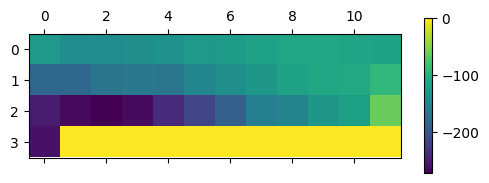

In [46]:
def TD_Lambda_Loop(env: TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0                   
        while True:
            At = env.sample_action(state, use_Qsa=False)  
            state_next, reward, terminal   = env.step(At)
            env.update_z(state)
            delta = env.target(reward,state, state_next)
            env.update_Wv(env.ALPHA,delta)
            state = state_next
            if terminal: break
    return 


env = TD_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.Wq[:,36],env.sample_action(36)
env.update_V()

TD_Lambda_Loop(env, N = 1000)
c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)

# True online TD($\lambda$) for estiamating $\vec{w}^T \vec{x} \approx v_\pi$
Well... Roughly speaking we want update weights in online manner, but still want to do n-step updates. We can unfold n-step updates and as new information is available re-calculate/update old calculation with estimator using most recent weights...

$$\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + (1 - \alpha \gamma \lambda \vec{z}_{t-1}^T \vec{x}_t)\vec{x}_t$$

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \delta_t \vec{z}_{t} + \alpha(\vec{w}_{t}^T \vec{x}_t - \vec{w}_{t-1}^T\vec{x}_t)\cdot (\vec{z}_{t}-\vec{x}_{t})$$

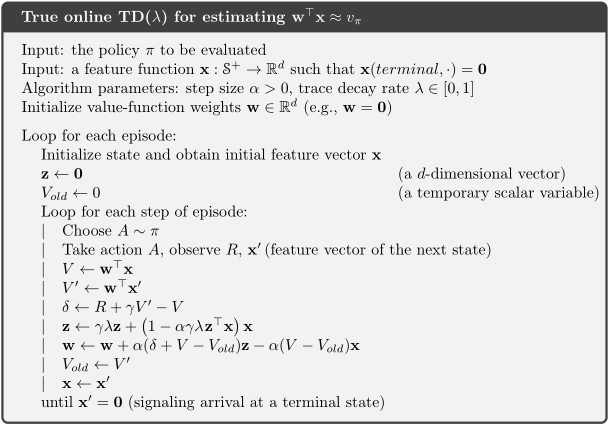

Approach of terminating at $\vec{x} = \vec{0}$ is probably means that $\vec{w}^T \vec{x} = 0$, so its understandable. Although there are other non-zero terms remaining.

100%|██████████| 1000/1000 [00:08<00:00, 121.26it/s]


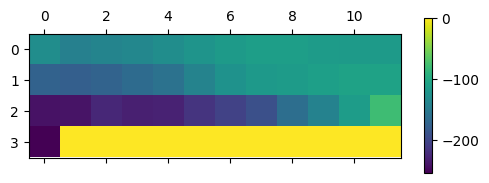

In [48]:
class True_online_TD_Lambda(env_approx):
    def __init__(self, env_name, state_space_discrete=True,  eps=0.1, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_space_discrete = state_space_discrete,  eps=eps, ALPHA=ALPHA, GAMMA=GAMMA, *args, **kwargs)    
        self.z = np.zeros_like(self.Wv)
        self.LAMBDA     = LAMBDA
        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA*LAMBDA
        self.V, self.Vp = 0,0
        self.delta      = 0
        self.states,   self.rewards = [], []

    def update_z(self,state):
        zTx = np.dot(self.z, self.Xs(state))
        self.z  = self.GL * self.z + (1 - self.AGL*zTx)*self.grad_Vs(state)

    def target(self, reward, state, state_next):
        self.V  = self.Vs(state)
        self.Vp = self.Vs(state_next)
        self.delta = reward + self.GAMMA *self.Vp - self.V

    def update_Wv(self, state, V_old):
        self.Wv +=  self.ALPHA*(self.delta + self.V - V_old)*self.z - \
                    self.ALPHA*(self.V - V_old)*self.Xs(state)
        
    
def True_online_TD_Lambda_Loop(env: True_online_TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0  
        V_old = 0                 
        while True:
            At = env.sample_action(state, use_Qsa=False)  
            state_next, reward, terminal   = env.step(At)
            env.target(reward, state, state_next)
            env.update_z(state)
            env.update_Wv(state, V_old)
            V_old = env.Vp
            state = state_next
            if terminal: break
    return 

env = True_online_TD_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.update_V()


True_online_TD_Lambda_Loop(env, N = 1000)

c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)

# Sarsa($\lambda$) with binary features an lin f-n approx $q_\pi \approx \vec{w}^T\vec{x}$ or $q_\ast$

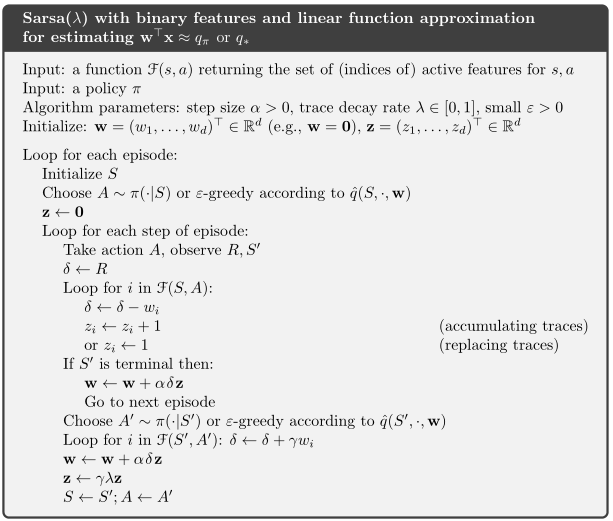

Regarding $\mathcal{F}(S,A)$ code segments. 

Ive defined default assumption of linear approximation as
$$\hat q(s,a, \vec{w}) = \sum_{i = 1}^d w_i(a) x_i(s)$$
if $x_i(s)$ is binary then $$\hat q(s,a, \vec{w}) = \sum_{i \in \mathcal{F}(S,A)} w_i(a)$$
and $\delta \leftarrow \delta - w_i$ loop reduces to $\delta  = \delta - \hat q(s,a, \vec{w})$

$z_i \leftarrow z_i + 1$ loop
is calculated via +1 modification of masked by $\vec{x}(S)$ of z: $\vec{z}(A,mask = \vec{x}(S)) = \{z_i:i \in \mathcal{F}(S,A)\}$ elements

In [11]:
class SARSA_Lambda(env_approx):
    def __init__(self, env_name, state_space_discrete=True,  eps=0.1, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_space_discrete = state_space_discrete,  eps=eps, ALPHA=ALPHA, GAMMA=GAMMA, *args, **kwargs)    
        self.z          = np.zeros_like(self.Wq)
        self.LAMBDA     = LAMBDA
        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA*LAMBDA
        self.V, self.Vp = 0,0
        #self.Xs         = self.Xs.astype(int)
        self.delta      = 0
        self.states,   self.rewards = [], []

    def update_z(self):
        self.z  *= self.GL

    def update_Wq(self, delta):
        self.Wq += self.ALPHA*delta*self.z 

def SARSA_Lambda_Loop(env: SARSA_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()   
        action = env.sample_action(state, use_Qsa=True)  
        env.z *= 0  
        t = 0
        while True:
            state_next, reward, terminal   = env.step(action)
            delta = reward
            delta -= env.Qsa(action, state)
            env.z[action, env.Xs(state).astype(bool)] += 1    # X(S) is binary
            if terminal: 
                env.Wq += env.ALPHA*delta*env.z
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)

                break
            action_next = env.sample_action(state_next, use_Qsa=True)  
            delta += env.GAMMA*env.Qsa(action_next, state_next)

            env.update_Wq(delta)
            env.update_z()

            state   = state_next
            action  = action_next
            t += 1
        
            
    return 

100%|██████████| 1000/1000 [00:09<00:00, 109.53it/s, T=19, env_iters=1000, eps=0.4]


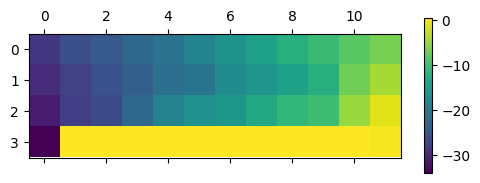

In [12]:
env = SARSA_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.update_V()


SARSA_Lambda_Loop(env, N = 1000)
env.update_V()
c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)


In [14]:
tx = ty = 40
tn = 8
tp = {'tiles_x' : tx, 'tiles_y' : ty, 'layers' : tn, 'offset' : [1/tx/tn]*2, 'max_entries_side' : 600}
env = None
env = SARSA_Lambda('MountainCar-v0',state_space_discrete=False, tile_params_d = tp, GAMMA = 1, ALPHA = 1/2/8)

In [17]:
SARSA_Lambda_Loop(env, N = 1000)

100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s, T=141, env_iters=2000, eps=0.1]


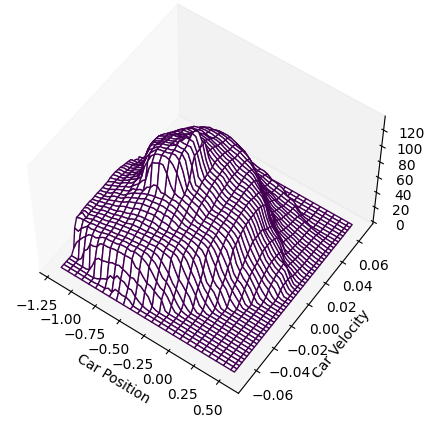

In [18]:
low                 = env.env.observation_space.low
high                = env.env.observation_space.high
minmax_x, minmax_y  = np.vstack((low,high)).T
x = np.arange(*minmax_x, (minmax_x[1]- minmax_x[0])/50)
y = np.arange(*minmax_y, (minmax_y[1]- minmax_y[0])/50)

z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    val = np.array([env.Qsa(a, (x[i], y[j])) for a in env.actions]).max()
    z[i,j] = val #en.Qsa(2, (x[i], y[j]))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, -z.T, rstride=1, cstride=2, shade=False, cmap=None, linewidth=1, label='Approximation')
surf.set_edgecolors(surf.to_rgba(surf._A))
surf.set_facecolors("white")
#wire = ax.plot_wireframe(X, Y, -z.T, rstride=2, cstride=5, linewidth = 0.5, label='True surface')
ax.view_init(elev=55., azim=-55)

ax.grid(False)
ax.set_xlabel('Car Position')
ax.set_ylabel('Car Velocity');

In [28]:
class True_SARSA_Lambda(env_approx):
    def __init__(self, env_name, state_space_discrete=True,  eps=0.1, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_space_discrete = state_space_discrete,  eps=eps, ALPHA=ALPHA, GAMMA=GAMMA, *args, **kwargs)    
        self.z          = np.zeros_like(self.Wq)
        self.LAMBDA     = LAMBDA
        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA*LAMBDA
        self.V, self.Vp = 0,0
        self.states,   self.rewards = [], []

def True_SARSA_Lambda_Loop(env: True_SARSA_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()   
        action = env.sample_action(state, use_Qsa=True)  
        x = env.Xs(state)
        env.z *= 0  
        Q_old = 0
        t = 0
        while True:
            state_next, reward, terminal   = env.step(action)
            if terminal: 
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)
                break
            action_next = env.sample_action(state_next, use_Qsa=True)
            xp = env.Xs(state_next)
            Q = env.Qsa(action,state)
            Qp = env.Qsa(action_next,state_next)
            delta = reward + env.GAMMA *Qp - Q
            ztx     = np.dot(env.z, x)
            env.z = env.GL*env.z +  (1-env.AGL*ztx)* x
            env.Wq += env.ALPHA*(delta + Q - Q_old)*env.z 
            env.Wq -= env.ALPHA*(Q - Q_old)*x
            Q_old = Qp
            x = xp
            action = action_next
            t += 1
        
            
    return 
True_SARSA_Lambda_Loop(env, N = 1000)

  0%|          | 0/1000 [00:42<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (3,) (200,) 

In [26]:
tx = ty = 10#40
tn = 2#8
tp = {'tiles_x' : tx, 'tiles_y' : ty, 'layers' : tn, 'offset' : [1/tx/tn]*2, 'max_entries_side' : 600}
env = None
env = True_SARSA_Lambda('MountainCar-v0',state_space_discrete=False, tile_params_d = tp, GAMMA = 1, ALPHA = 1/2/8)

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (3,) (12800,) 